In [2]:
import warnings
import os
import numpy as np
import xarray as xr
from xMCA import xMCA
import pandas as pd
import seaborn as sns
from eofs.xarray import Eof
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec# Create 2x2 sub plots
import cftime
from matplotlib.dates import DateFormatter
from matplotlib import colorbar, colors
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

# Load Data

In [5]:
da_sst= xr.open_dataset('https://www.psl.noaa.gov/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc')
da_pr= xr.open_dataset('https://www.psl.noaa.gov/thredds/dodsC/Datasets/prec/precip.mon.anom.nc')

da_sst = da_sst.sel(time=slice("1979", "2020")).load()
da_pr = da_pr.sel(time=slice("1979", "2020")).load()
da_sst
da_pr

<xarray.Dataset>
Dimensions:    (lat: 89, lon: 180, nbnds: 2, time: 502)
Coordinates:
  * lat        (lat) float32 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon        (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2020-10-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 9.969e+36 9.969e+36 ... 9.969e+36 9.969e+36
    sst        (time, lat, lon) float32 -1.8 -1.8 -1.8 -1.8 ... nan nan nan nan
Attributes:
    climatology:                     Climatology is based on 1971-2000 SST, X...
    description:                     In situ data: ICOADS2.5 before 2007 and ...
    keywords_vocabulary:             NASA Global Change Master Directory (GCM...
    keywords:                        Earth Science > Oceans > Ocean Temperatu...
    instrument:                      Conventional thermometers
    source_comment:                  SSTs were observed by conventional therm...
    geospatial_lon_min:              -1.0
    geospatial_lon_max:              359.0
    geospatial_laty_max:             89.0
    geospatial_laty_min:             -89.0
    geospatial_lat_max:              89.0
    geospatial_lat_min:              -89.0
    geospatial_lat_units:            degrees_north
    geospatial_lon_units:            degrees_east
    cdm_data_type:                   Grid
    project:                         NOAA Extended Reconstructed Sea Surface ...
    original_publisher_url:          http://www.ncdc.noaa.gov
    References:                      https://www.ncdc.noaa.gov/data-access/ma...
    source:                          In situ data: ICOADS R3.0 before 2015, N...
    title:                           NOAA ERSSTv5 (in situ only)
    history:                         created 07/2017 by PSD data using NCEI's...
    institution:                     This version written at NOAA/ESRL PSD: o...
    citation:                        Huang et al, 2017: Extended Reconstructe...
    platform:                        Ship and Buoy SSTs from ICOADS R3.0 and ...
    standard_name_vocabulary:        CF Standard Name Table (v40, 25 January ...
    processing_level:                NOAA Level 4
    Conventions:                     CF-1.6, ACDD-1.3
    metadata_link:                   :metadata_link = https://doi.org/10.7289...
    creator_name:                    Boyin Huang (original)
    date_created:                    2017-06-30T12:18:00Z (original)
    product_version:                 Version 5
    creator_url_original:            https://www.ncei.noaa.gov
    license:                         No constraints on data access or use
    comment:                         SSTs were observed by conventional therm...
    summary:                         ERSST.v5 is developed based on v4 after ...
    dataset_title:                   NOAA Extended Reconstructed SST V5
    data_modified:                   2020-11-06
    DODS_EXTRA.Unlimited_Dimension:  time

<xarray.Dataset>
Dimensions:  (lat: 72, lon: 144, time: 502)
Coordinates:
  * lat      (lat) float32 88.75 86.25 83.75 81.25 ... -83.75 -86.25 -88.75
  * lon      (lon) float32 1.25 3.75 6.25 8.75 ... 351.25 353.75 356.25 358.75
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2020-10-01
Data variables:
    precip   (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    Conventions:                     CF-1.2
    title:                           Precipitation Reconstruction (PREC): 2.5...
    history:                         Tue Jun 28 10:57:05 2011: ncea -F -d tim...
    platform:                        Analyses
    institution:                     NOAA ESRL/PSD
    References:                      https://www.psl.noaa.gov/data/gridded/da...
    citation:                        Chen, M., P. Xie, J. E. Janowiak, and P....
    nco_openmp_thread_number:        1
    dataset_title:                   Precipitation Reconstruction (PREC)
    data_modified:                   2020-11-03
    DODS_EXTRA.Unlimited_Dimension:  time

In [7]:
#Regridding datasets to similar grid resolution
da_pr = (da_pr.interp_like(da_sst.sst)).load()

# Climate Modes

Climate can be defined as the long-term average of weather, usually averaged for at least 30 years. The mean state of the climate is determined by the interactions between the earth system components. Their interactions involve the exchange mass, momentum and energy on all spatio-temporal scales. As a consequence, global or regional scale climate variables such as the sea surface temperature, the rainfall, the surface pressure or the wind speed fluctuate somewhat regularly. This regular fluctuation is a natural form of climate variability, which are individually known as modes or oscillations. Their phases and states are monitored by different types of climate models. There are many known oscillations which extend over larges areas across the globe. Examples are:

- El Niño-Southern Oscillation (ENSO)
- North Atlantic Oscillation (NAO)
- Atlantic Multidecadal Oscillation (AMO)
- Pacific North American pattern (PNA)
- Pacific Decadal Oscillation (PDO)
- Northern Annular Mode (NAM; previously called the Arctic Oscillation, AO)
- Southern Annular Mode (SAM; previously called the Antarctic Oscillation, AAO

In this notebook, I aim to calculate the monthly indices of each climate mode starting with ENSO, which is the most popular with large global impacts.

**Calculate climatology and monthly anomalies for all variables**

In [10]:
#Climatology
da_clim = da_sst.groupby('time.month').mean(dim='time')
#Anomalies for SST
da_ano = da_sst.groupby('time.month') - da_clim

In [11]:
da_ano['precip']=da_pr.precip; #Include the precipitation anomalies in the central anomaly dataset
da_ano = (da_ano.reset_coords(names=['month'], drop=True)).load()
da_ano;

# **1. El Niño-Southern Oscillation (ENSO)**

The El Niño-Southern Oscillation (ENSO) is a recurring climate pattern that involves fluctuating ocean temperatures in the central and eastern equatorial Pacific, coupled with changes in the atmosphere. It fluctuates between three phases: Neutral, La Niña (cold) or El Niño (warm). ENSO affects the distribution of rainfall in the tropics and can strongly modifies weather conditions in various part of the world. 

Here, we will calculate the ENSO index using Nino3.4 region (*5N-5S, 170W - 120W*) and Emperical Orthogonal Function(EOFs) of the tropical pacific. Thereafter, we will perform correlation between the two time series. Lastly, we will also connsider the DJF analysis since ENSO occurs during the boreal winter season

[Learn more about ENSO](https://iridl.ldeo.columbia.edu/maproom/ENSO/ENSO_Info.html "What is ENSO?")


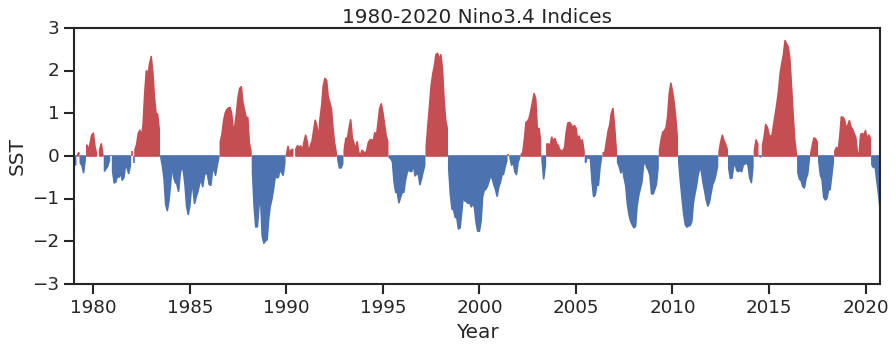

In [13]:
#Calculate the Nino 3.4 index
da_sst_reg=(da_ano.sst.sel(lon=slice(190,240), lat=slice(5,-5))).mean(dim=['lon','lat'])
sns.set(style="ticks", context="talk")
#plt.style.use("classic")
plt.figure(figsize=(13,4))
plt.fill_between(da_sst_reg.time.values, 0, da_sst_reg, where= da_sst_reg>0, facecolor='r', edgecolor='r')
plt.fill_between(da_sst_reg.time.values, 0, da_sst_reg, where= da_sst_reg<0, facecolor='b', edgecolor='b')
#sns.despine(offset=10)
plt.title('1980-2020 Nino3.4 Indices')
plt.ylabel('SST')
plt.xlabel('Year');

**EOF Method**

In [15]:
da_trop_reg=(da_ano.sst.sel(lon=slice(100,310), lat=slice(20,-20))) #Select the region
solver = Eof(da_trop_reg) #Eof package
eof1 = solver.eofsAsCovariance(neofs=1) # Select the first mode
pc1 = solver.pcs(npcs=1, pcscaling=1)
variance_fractions = solver.varianceFraction(neigs=1)
variance_fractions;

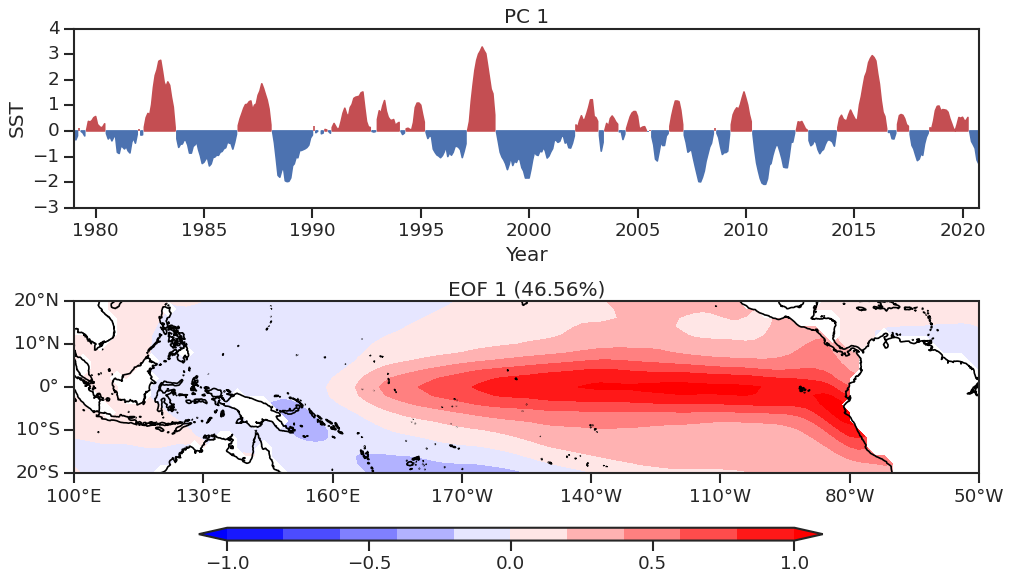

In [16]:
fig = plt.figure(figsize=(13,8))
ax = fig.add_subplot(2,1,2, projection = ccrs.PlateCarree(180))
clevs = np.arange(-1,1.2,0.2)
cs=ax.contourf(da_trop_reg.lon,da_trop_reg.lat,eof1.isel(mode=0),clevs,transform = ccrs.PlateCarree(),cmap='bwr',extend='both')
ax.coastlines()
ax.set_yticks(np.arange(-20,30,10), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)

ax.set_xticks(np.arange(100,330,30), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.set_title('EOF 1' + ' (' +  "{:05.2f}".format(variance_fractions.values[0]*100) +'%)' )
cbar_ax = fig.add_axes([0.2, 0.10, 0.6, 0.02])
fig.colorbar(cs,cax=cbar_ax, shrink=0.65, orientation='horizontal', ticks=np.arange(-1,1.5,0.5))

ax = fig.add_subplot(2, 1, 1)
ax.fill_between(da_sst_reg.time.values, 0, pc1.isel(mode=0), where= pc1.isel(mode=0)>0, facecolor='r', edgecolor='r')
ax.fill_between(da_sst_reg.time.values, 0, pc1.isel(mode=0), where= pc1.isel(mode=0)<0, facecolor='b', edgecolor='b');
ax.set_title('PC 1')
ax.set_ylabel('SST')
ax.set_xlabel('Year');

fig.subplots_adjust(bottom=0.2, top=0.9, left=0.08, right=0.95, wspace=0.05, hspace=0.5);


Now let's compute the correlation between Nino 3.4 region time series and PC1 index

In [17]:
#Correlation between box averaged Nino3.4 region and PC1
cr_nino_pc = xr.corr(da_sst_reg, pc1)
print("The correlation of box averaged Nino3.4 and PC1 is :", "{:04.2f}".format(cr_nino_pc.values))

The correlation of box averaged Nino3.4 and PC1 is : 0.96


## Now let's focus on boreal winter season (DJF) and repeat previous analysis

In [18]:
#DJF computation

da_ano_djf = da_ano.sel(time=(da_ano['time.season'] == 'DJF'));

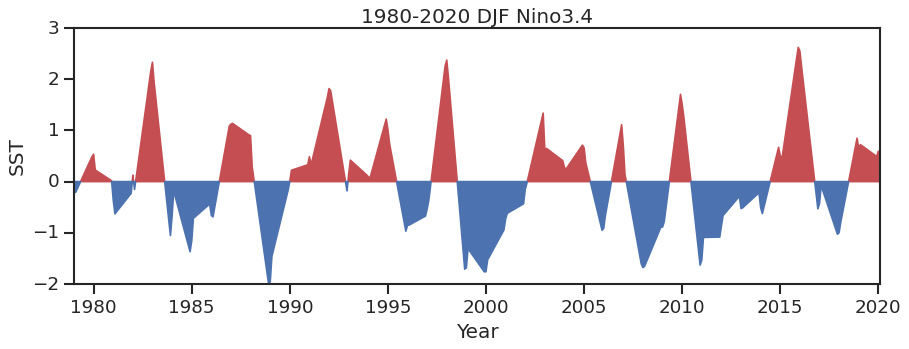

In [20]:
da_sst_reg_djf=(da_ano_djf.sst.sel(lon=slice(190,240), lat=slice(5,-5))).mean(dim=['lon','lat'])

sns.set(style="ticks", context="talk")
#plt.style.use("classic")
plt.figure(figsize=(13,4))
plt.fill_between(da_sst_reg_djf.time.values, 0, da_sst_reg_djf, where= da_sst_reg_djf>0, facecolor='r', edgecolor='r',interpolate=True)
plt.fill_between(da_sst_reg_djf.time.values, 0, da_sst_reg_djf, where= da_sst_reg_djf<0, facecolor='b', edgecolor='b', interpolate=True)
#sns.despine(offset=10)
plt.title('1980-2020 DJF Nino3.4')
plt.ylabel('SST')
plt.xlabel('Year');

In [21]:
#EOF
da_trop_reg_djf=(da_ano_djf.sst.sel(lon=slice(100,310), lat=slice(20,-20)))
solver = Eof(da_trop_reg_djf)
eof1 = solver.eofsAsCovariance(neofs=1)
pc1 = solver.pcs(npcs=1, pcscaling=1)
variance_fractions = solver.varianceFraction(neigs=1)
variance_fractions;

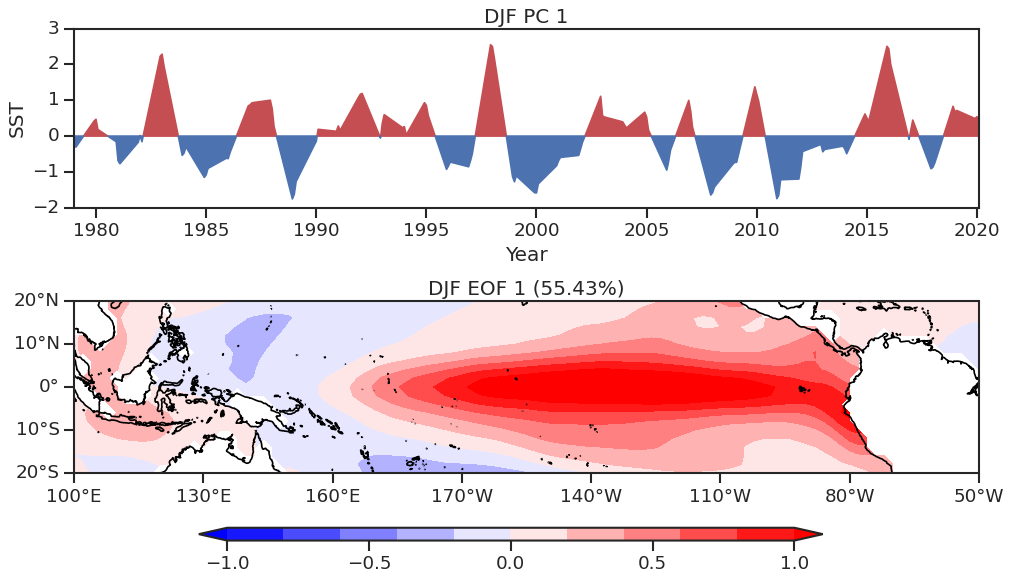

In [22]:
fig = plt.figure(figsize=(13,8))
ax = fig.add_subplot(2,1,2, projection = ccrs.PlateCarree(180))
clevs = np.arange(-1,1.2,0.2)
cs=ax.contourf(da_trop_reg_djf.lon,da_trop_reg_djf.lat,eof1.isel(mode=0),clevs,transform = ccrs.PlateCarree(),cmap='bwr',extend='both')
ax.coastlines()
ax.set_yticks(np.arange(-20,30,10), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)

ax.set_xticks(np.arange(100,330,30), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.set_title('DJF EOF 1' + ' (' +  "{:05.2f}".format(variance_fractions.values[0]*100) +'%)' )
cbar_ax = fig.add_axes([0.2, 0.10, 0.6, 0.02])
fig.colorbar(cs,cax=cbar_ax, shrink=0.65, orientation='horizontal', ticks=np.arange(-1,1.5,0.5))

ax = fig.add_subplot(2, 1, 1)
ax.fill_between(da_trop_reg_djf.time.values, 0, pc1.isel(mode=0), where= pc1.isel(mode=0)>0, facecolor='r', edgecolor='r',interpolate=True)
ax.fill_between(da_trop_reg_djf.time.values, 0, pc1.isel(mode=0), where= pc1.isel(mode=0)<0, facecolor='b', edgecolor='b',interpolate=True);
ax.set_title('DJF PC 1')
ax.set_ylabel('SST')
ax.set_xlabel('Year');

fig.subplots_adjust(bottom=0.2, top=0.9, left=0.08, right=0.95, wspace=0.05, hspace=0.5);


In [23]:
cr_nino_pc_djf = xr.corr(da_sst_reg_djf, pc1)
print("The DJF correlation of box averaged Nino3.4 and PC1 is :",  "{:04.2f}".format(cr_nino_pc_djf.values))

The DJF correlation of box averaged Nino3.4 and PC1 is : 0.98


In [320]:
cr_nino = xr.corr(da_sst_reg_djf, pc1.isel(mode=0))

print("The correlation of box averaged Nino3.4 and PC2 is :", cr_nino.values)

The correlation of box averaged Nino3.4 and PC2 is : 0.9856318114624778


# ENSO Teleconnections - Global precipitation impacts during ENSO events
Changes in the atmosphere in one location can affect normal weather conditions in many parts of the world. ENSO effects are called teleconnecions. Now let's use regression analysis to show the amount of precipitation changes in parts of the globe during ENSO events

## Regression of  precipitation anomalies on Nino3.4

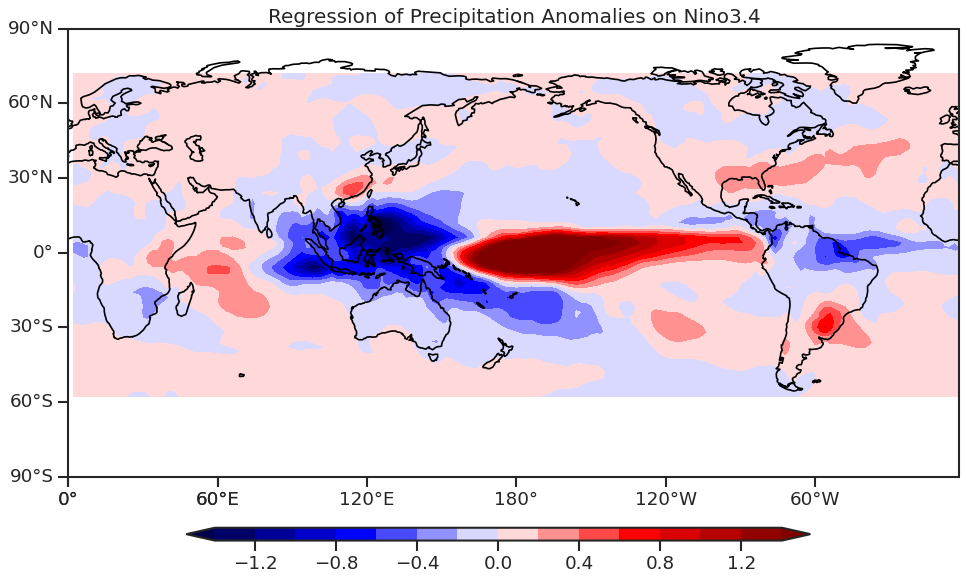

In [24]:
#Regression

xr_cov = xr.cov(da_sst_reg,da_ano.precip,  dim='time');
xr_var = da_sst_reg.var(dim='time')
reg_coeff = xr_cov/xr_var

fig = plt.figure(figsize=(13,8))
ax = fig.add_subplot(1,1,1, projection = ccrs.PlateCarree(180))
clevs = np.arange(-1.4,1.6,0.2)
cs=ax.contourf(da_ano.lon,da_ano.lat,reg_coeff,clevs,transform = ccrs.PlateCarree(),cmap='seismic',extend='both')
ax.coastlines()
ax.set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)

ax.set_xticks(np.arange(0,422,60), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.set_title('Regression of Precipitation Anomalies on Nino3.4' )
cbar_ax = fig.add_axes([0.2, 0.10, 0.6, 0.02])
fig.colorbar(cs,cax=cbar_ax, shrink=0.65, orientation='horizontal');
fig.subplots_adjust(bottom=0.2, top=0.9, left=0.08, right=0.95, wspace=0.05, hspace=0.5);

![title](https://www.weather.gov/images/fwd/climate/enso/ElNino.png)



# **2. Indian Ocean Dipole**

The Indian Ocean Dipole (IOD) is an irregular oscillation of sea surface temperatures in which the western Indian Ocean becomes alternately warmer (positive phase) and then colder (negative phase) than the eastern part of the ocean. The IOD has three phases: neutral, positive and negative. IOD typically starts around May or June and peaks between September – November. The strength of the IOD is monitored with the so-called Dipole Mode Index, which is defined as the difference in sea surface temperatures between the eastern and western tropical Indian Ocean. IOD is the second dominant pattern of variability in the tropical Indian Ocean after the gravest basin-wide mode related to ENSO events. 

IOD sufficiently modifies the wind, temperature, and rainfall patterns of surronding regions, typically bringing floods to eastern Africa and droughts and bushfires to eastern Asia and Australia, among other ecological and socio-economic impacts.

[Learn more about IOD](https://www.climate.gov/news-features/blogs/enso/meet-enso%E2%80%99s-neighbor-indian-ocean-dipole#:~:text=This%20east%2Dwest%20contrast%20in,ecological%20and%20socio%2Deconomic%20impacts. "Meet the Indian Ocean Dipole")


<Figure size 1600x640 with 0 Axes>

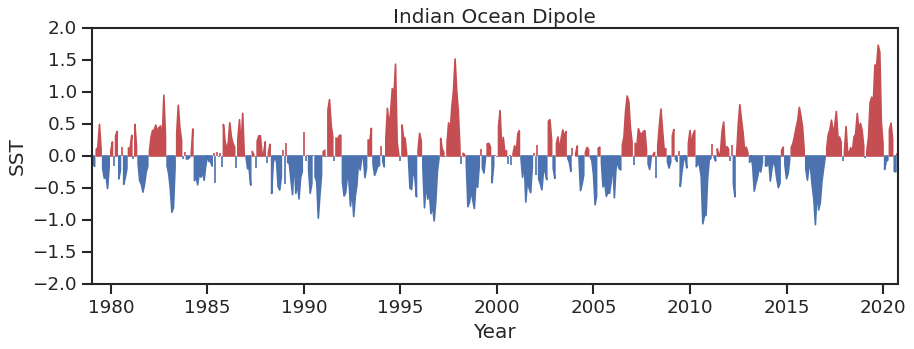

In [25]:
WIOD = (da_ano.sst.sel(lon=slice(50,70), lat=slice(10,-10))).mean(dim=['lon','lat']) #western Indian Ocean
EIOD = (da_ano.sst.sel(lon=slice(90,110), lat=slice(0,-10))).mean(dim=['lon','lat']) #eastern
IOD = WIOD - EIOD

fg = plt.figure(figsize=(20,8))
sns.set(style="ticks", context="talk")
#plt.style.use("classic")
plt.figure(figsize=(13,4))
plt.fill_between(IOD.time.values, 0, IOD, where= IOD>0, facecolor='r', edgecolor='r')
plt.fill_between(IOD.time.values, 0, IOD, where= IOD<0, facecolor='b', edgecolor='b')
#sns.despine(offset=10)
plt.title('Indian Ocean Dipole')
plt.ylabel('SST')
plt.xlabel('Year');
plt.ylim([-2, 2]);



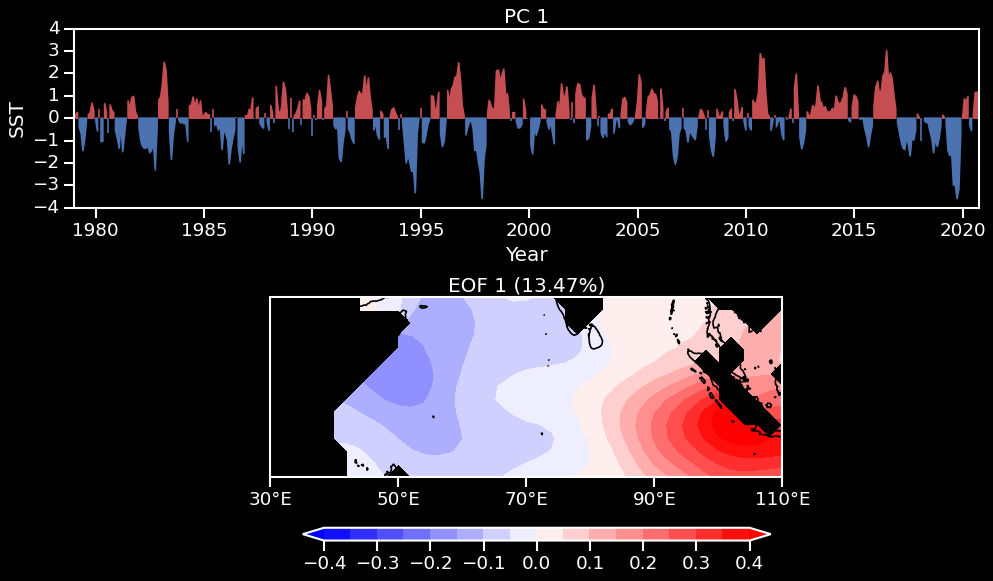

In [26]:
#EOF
da_io_reg=(da_ano.sst.sel(lon=slice(30,110), lat=slice(15,-15)))
solver = Eof(da_io_reg)
eof_iod = solver.eofsAsCovariance(neofs=2)
pc_iod = solver.pcs(npcs=2, pcscaling=1)
variance_fractions = solver.varianceFraction(neigs=2)
variance_fractions

sns.set(style="ticks", context="talk")
plt.style.use("dark_background")
fig = plt.figure(figsize=(13,8))
ax = fig.add_subplot(2,1,2, projection = ccrs.PlateCarree(180))
clevs = np.arange(-0.4,0.45,0.05)
cs=ax.contourf(da_io_reg.lon,da_io_reg.lat,eof_iod.isel(mode=1),clevs,transform = ccrs.PlateCarree(),cmap='bwr',extend='both')
ax.coastlines()
ax.set_yticks(np.arange(-15,-20,5), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)

ax.set_xticks(np.arange(30,130,20), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.set_title('EOF 1' + ' (' +  "{:05.2f}".format(variance_fractions.values[1]*100) +'%)' )
cbar_ax = fig.add_axes([0.3, 0.10, 0.45, 0.02])
fig.colorbar(cs,cax=cbar_ax, shrink= 0.9, orientation='horizontal')

ax = fig.add_subplot(2, 1, 1)
ax.fill_between(da_io_reg.time.values, 0, pc_iod.isel(mode=1), where= pc_iod.isel(mode=1)>0, facecolor='r', edgecolor='r')
ax.fill_between(da_io_reg.time.values, 0, pc_iod.isel(mode=1), where= pc_iod.isel(mode=1)<0, facecolor='b', edgecolor='b');
ax.set_title('PC 1')
ax.set_ylabel('SST')
ax.set_xlabel('Year');

fig.subplots_adjust(bottom=0.2, top=0.9, left=0.08, right=0.95, wspace=0.05, hspace=0.5);


In [30]:
#Correlation between box averaged IOD region and PC2

cr_iod = xr.corr(IOD, pc_iod.isel(mode=1))
print("The correlation of box averaged IOD and PC2 is :", "{:04.2f}".format(cr_iod.values))


The correlation of box averaged IOD and PC2 is : -0.95


<Figure size 1600x640 with 0 Axes>

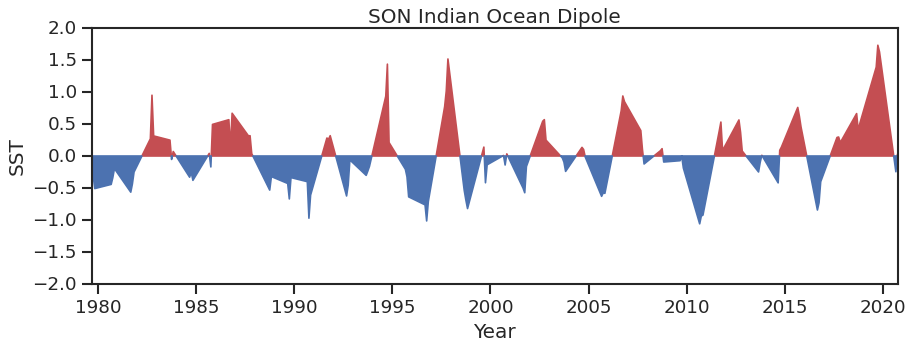

In [28]:
#SON computation
da_ano_son = da_ano.sel(time=(da_ano['time.season'] == 'SON'))

WIOD_son = (da_ano_son.sst.sel(lon=slice(50,70), lat=slice(10,-10))).mean(dim=['lon','lat'])
EIOD_son = (da_ano_son.sst.sel(lon=slice(90,110), lat=slice(0,-10))).mean(dim=['lon','lat'])
IOD_son = WIOD_son - EIOD_son

fg = plt.figure(figsize=(20,8))
sns.set(style="ticks", context="talk")
#plt.style.use("classic")
plt.figure(figsize=(13,4))
plt.fill_between(IOD_son.time.values, 0, IOD_son, where= IOD_son>0, facecolor='r', edgecolor='r',interpolate=True)
plt.fill_between(IOD_son.time.values, 0, IOD_son, where= IOD_son<0, facecolor='b', edgecolor='b',interpolate=True)
#sns.despine(offset=10)
plt.title('SON Indian Ocean Dipole')
plt.ylabel('SST')
plt.xlabel('Year');
plt.ylim([-2, 2]);


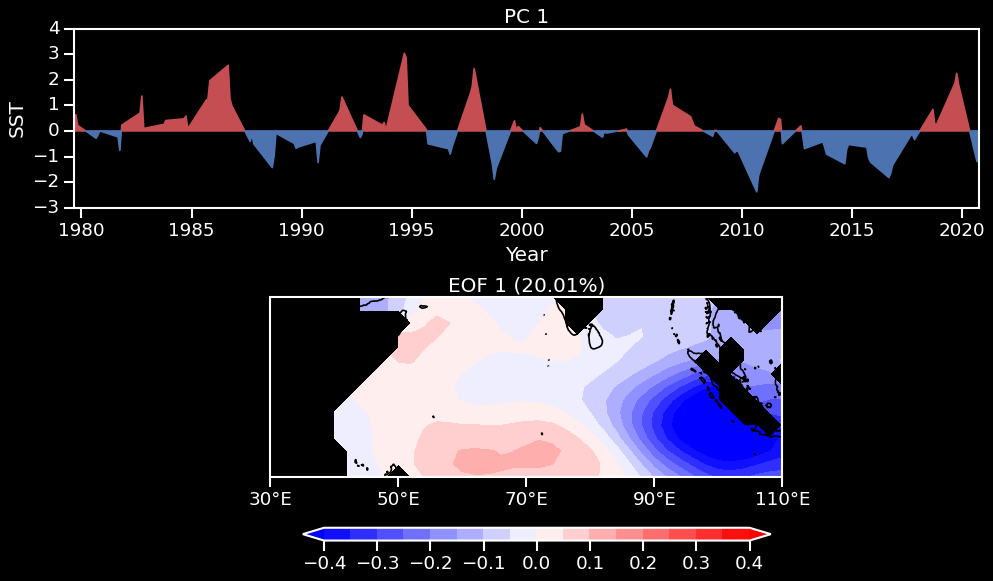

In [29]:
#EOF for SON
da_io_reg_son=(da_ano_son.sst.sel(lon=slice(30,110), lat=slice(15,-15)))
solver = Eof(da_io_reg_son)
eof_iod_son = solver.eofsAsCovariance(neofs=2)
pcs_iod_son = solver.pcs(npcs=2, pcscaling=1)
variance_fractions = solver.varianceFraction(neigs=2)
variance_fractions

sns.set(style="ticks", context="talk")
plt.style.use("dark_background")
fig = plt.figure(figsize=(13,8))
ax = fig.add_subplot(2,1,2, projection = ccrs.PlateCarree(180))
clevs = np.arange(-0.4,0.45,0.05)
cs=ax.contourf(da_io_reg_son.lon,da_io_reg_son.lat,-eof_iod_son.isel(mode=1),clevs,transform = ccrs.PlateCarree(),cmap='bwr',extend='both')
ax.coastlines()
ax.set_yticks(np.arange(-15,-20,5), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)

ax.set_xticks(np.arange(30,130,20), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.set_title('EOF 1' + ' (' +  "{:05.2f}".format(variance_fractions.values[1]*100) +'%)' )
cbar_ax = fig.add_axes([0.3, 0.10, 0.45, 0.02])
fig.colorbar(cs,cax=cbar_ax, shrink= 0.9, orientation='horizontal')

pcs_iod_son = -1*pcs_iod_son; #invert the pc signs to indicate warmer than normal in the western tropical indian ocean
ax = fig.add_subplot(2, 1, 1)
ax.fill_between(da_io_reg_son.time.values, 0, pcs_iod_son.isel(mode=1), where= pcs_iod_son.isel(mode=1)>0, facecolor='r', edgecolor='r',interpolate=True)
ax.fill_between(da_io_reg_son.time.values, 0, pcs_iod_son.isel(mode=1), where= pcs_iod_son.isel(mode=1)<0, facecolor='b', edgecolor='b',interpolate=True);
ax.set_title('PC 1')
ax.set_ylabel('SST')
ax.set_xlabel('Year');

fig.subplots_adjust(bottom=0.2, top=0.9, left=0.08, right=0.95, wspace=0.05, hspace=0.5);

In [31]:
#Correlation between box averaged IOD region and PC2 for SON

cr_iod_son = xr.corr(IOD_son, pcs_iod_son.isel(mode=1))
print("The correlation of box averaged IOD and PC2 for SON season is :", "{:04.2f}".format(cr_iod_son.values))


The correlation of box averaged IOD and PC2 for SON season is : 0.76


In [436]:
da_io

<xarray.Dataset>
Dimensions:  (lat: 37, lon: 73, time: 502)
Coordinates:
  * lat      (lat) float64 40.0 37.5 35.0 32.5 30.0 ... -42.5 -45.0 -47.5 -50.0
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 172.5 175.0 177.5 180.0
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2020-10-01
Data variables:
    mslp     (time, lat, lon) float32 -794.7656 -699.40625 ... 688.40625
    sst      (time, lat, lon) float64 0.2877 0.169 -0.06195 ... 0.0879 0.05084
    uwnd     (time, lat, lon) float64 -0.8386 -0.9918 -0.6141 ... 1.405 1.795
    vwnd     (time, lat, lon) float64 1.89 1.888 1.344 ... -0.399 -0.2372
    precip   (time, lat, lon) float64 nan nan 0.7695 ... 0.1729 0.1908 0.1502

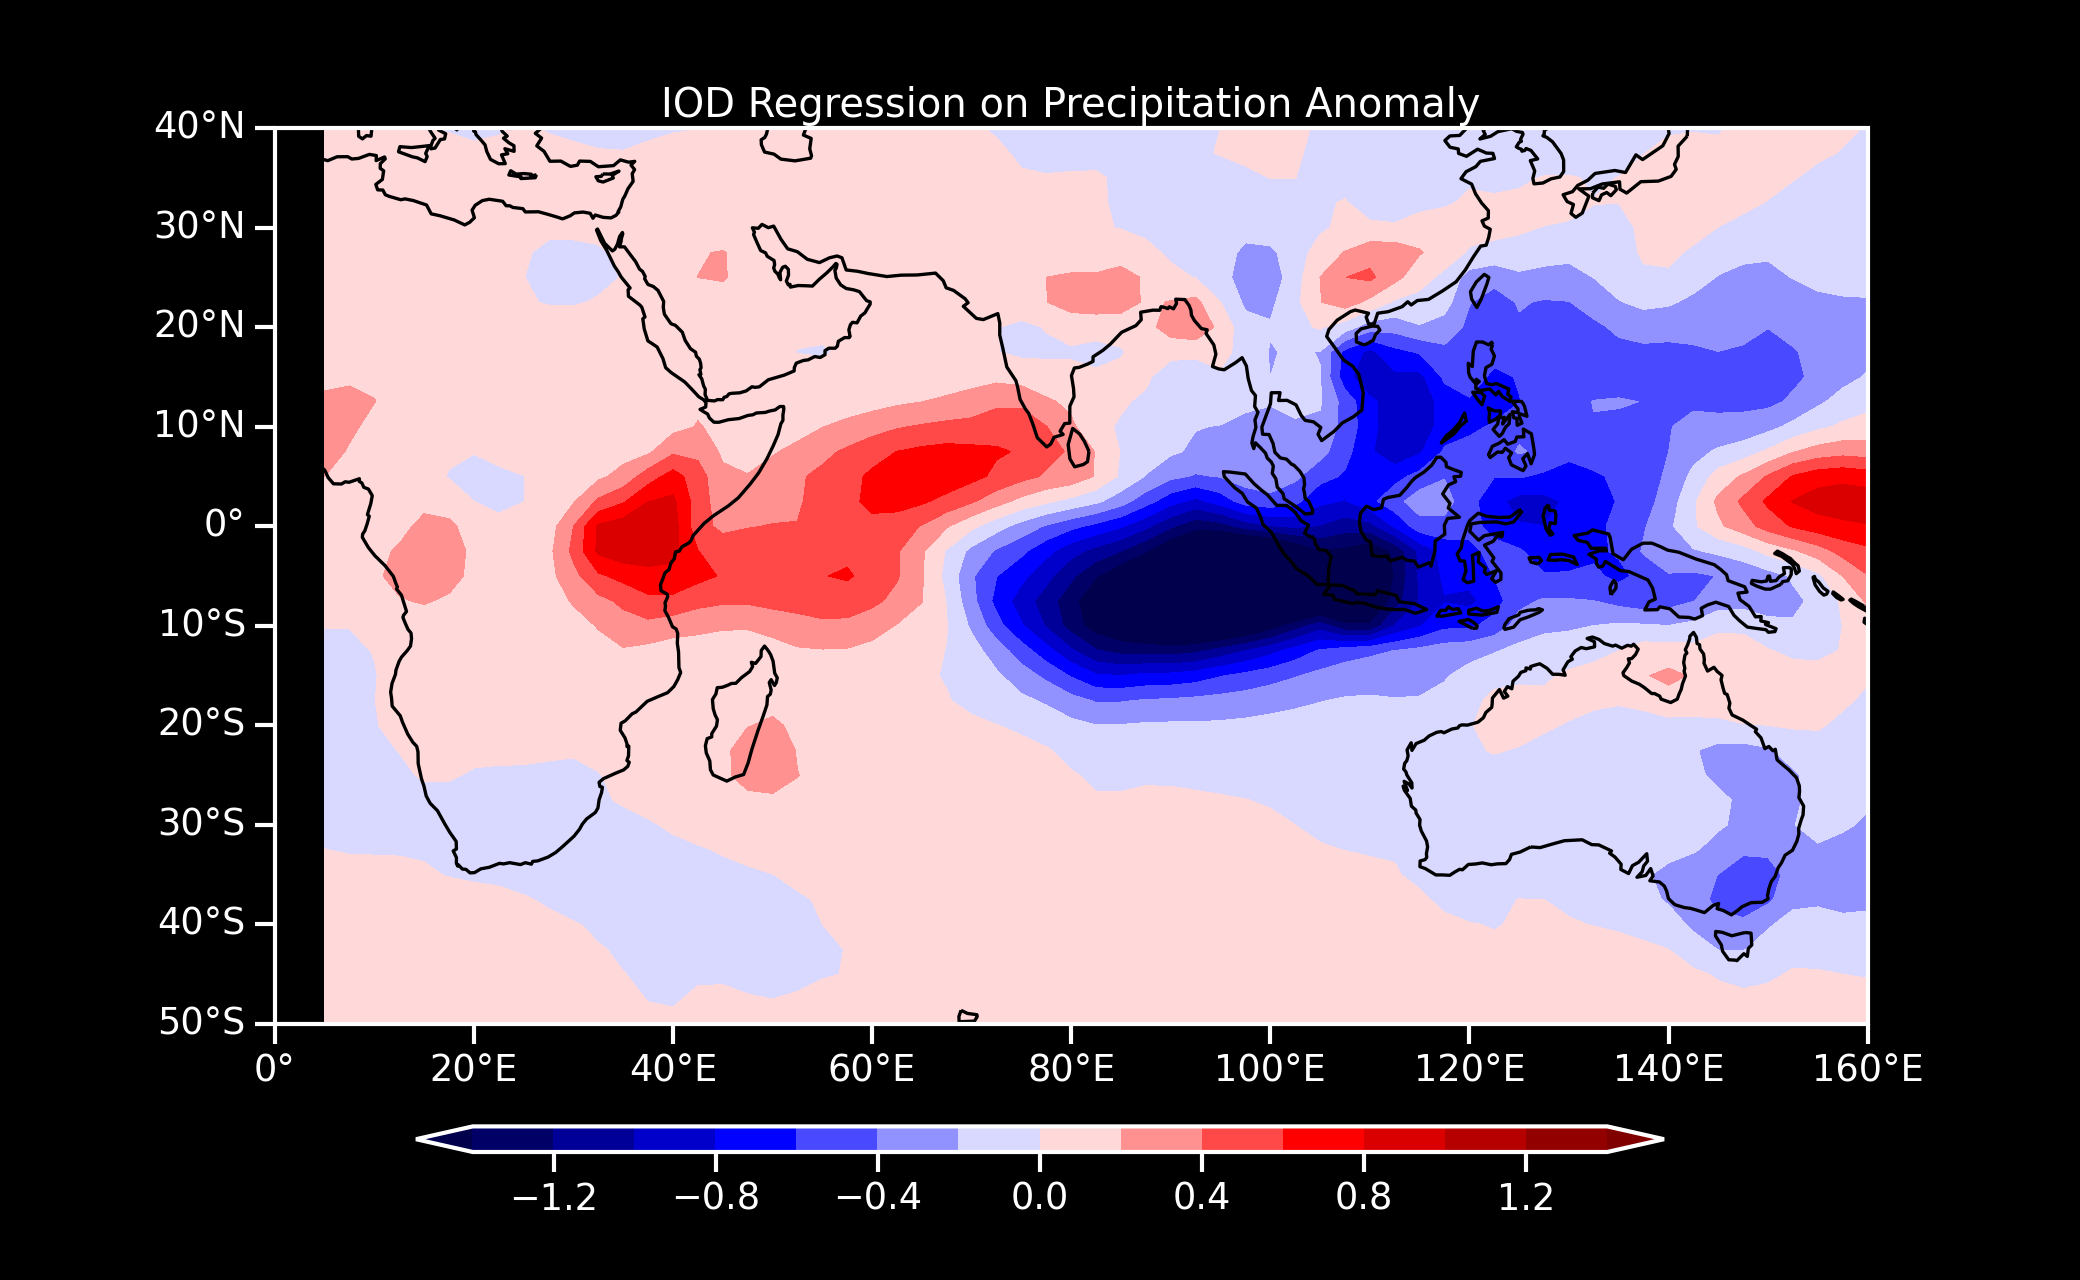

In [442]:
#Regression
da_io=(da_ano.sel(lon=slice(0,160), lat=slice(40,-50)))

xr_cov = xr.cov(IOD, da_io.precip,  dim='time');
xr_var = IOD.var(dim='time')
reg_coeff = xr_cov/xr_var

fig = plt.figure(figsize=(13,8))
ax = fig.add_subplot(1,1,1, projection = ccrs.PlateCarree(180))
clevs = np.arange(-1.4,1.6,0.2)

cs=ax.contourf(da_io.lon,da_io.lat,reg_coeff,clevs,transform = ccrs.PlateCarree(),cmap='seismic',extend='both')
ax.coastlines()
ax.set_yticks(np.arange(-50,50,10), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)

ax.set_xticks(np.arange(0,180,20), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.set_title('IOD Regression on Precipitation Anomaly' )
cbar_ax = fig.add_axes([0.2, 0.10, 0.6, 0.02])
fig.colorbar(cs,cax=cbar_ax, shrink=0.65, orientation='horizontal');
fig.subplots_adjust(bottom=0.2, top=0.9, left=0.08, right=0.95, wspace=0.05, hspace=0.5);
